In [ ]:
%%html
<style>div.input{display:none} div.output_stderr{display:none}</style>

# Kaplan-Meier
[Usage Example: Github](https://github.com/dlanier/notebooks_KnowEnG/blob/master/docs/Kaplan_Meier.md)

In [1]:
%pylab inline

import warnings
warnings.filterwarnings('ignore')

import os
import io
import sys
import base64

import pandas as pd
from pandas.io.common import EmptyDataError
import numpy as np

from IPython.display import display, HTML, clear_output
import ipywidgets as widgets
import traitlets

from knpackage import toolbox as kn

sys.path.insert(1, './src')
from layout_notebooks import *

from   lifelines import KaplanMeierFitter
from   lifelines.statistics import logrank_test, multivariate_logrank_test, pairwise_logrank_test

results_dir = USER_RESULTS_DIRECTORY
input_data_dir = USER_DATA_DIRECTORY
clear_output()

Box(children=(Dropdown(index=5, layout=Layout(width='50%'), options=('average_labels.tsv', 'average_spreadsheet.tsv', 'descriptive_statistic_spreadsheet.tsv', 'intersect_spreadsheet_A.tsv', 'intersect_spreadsheet_B.tsv', 'Kaplan_Meijer_data.tsv', 'merge_spreadsheet_A.txt', 'merge_spreadsheet_B.txt', 'other_transforms_spreadsheet.tsv', 'select_phenotype_phenotype.txt', 'select_phenotype_spreadsheet.df', 'select_rows_list.txt', 'select_rows_spreadsheet.tsv', 'transpose_spreadsheet.tsv'), value='Kaplan_Meijer_data.tsv'), Button(description='View', style=ButtonStyle(), tooltip='visualize selected file')), layout=Layout(align_items='stretch', border='none', display='inline-flex', flex_flow='row', justify_content='space-between', width='100%'))

HTML(value='')

HBox(children=(VBox(children=(Dropdown(description='Cluster_ID', options=('ClusterID', 'eomthsdicunpal', 'event', 'mehpalctunisod', 'mupacnodtliseh', 'ntolihpsdeacmu', 'pdiuhascltnoem', 'seahiocndtlpum', 'sihnmldoepcaut', 'snauhdplotcmei', 'time', 'ulmsicpdnthaeo', 'utohdasipcnlme'), value='ClusterID'), Dropdown(description='event', index=2, options=('ClusterID', 'eomthsdicunpal', 'event', 'mehpalctunisod', 'mupacnodtliseh', 'ntolihpsdeacmu', 'pdiuhascltnoem', 'seahiocndtlpum', 'sihnmldoepcaut', 'snauhdplotcmei', 'time', 'ulmsicpdnthaeo', 'utohdasipcnlme'), value='event'), Dropdown(description='time', index=10, options=('ClusterID', 'eomthsdicunpal', 'event', 'mehpalctunisod', 'mupacnodtliseh', 'ntolihpsdeacmu', 'pdiuhascltnoem', 'seahiocndtlpum', 'sihnmldoepcaut', 'snauhdplotcmei', 'time', 'ulmsicpdnthaeo', 'utohdasipcnlme'), value='time'))),), layout=Layout(display='flex', flex_flow='row', justify_content='flex-start', width='100%'))

HBox(children=(Button(description='Show', style=ButtonStyle(), tooltip='execute selected file'),), layout=Layout(display='flex', flex_flow='row', justify_content='flex-end', width='100%'))

HTML(value='')


	 multivariate_logrank_test
p_value  2.2672492512e-93


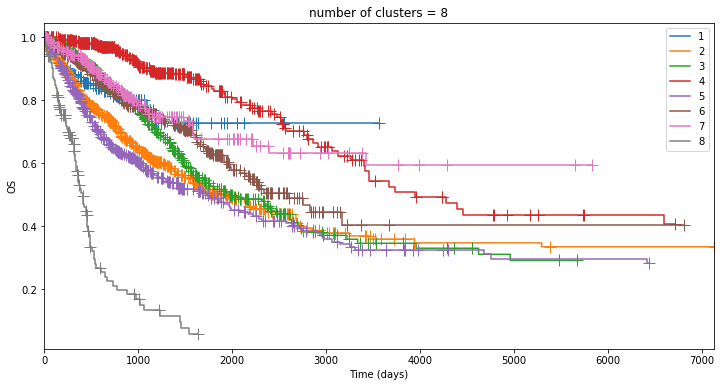

In [2]:
get_km_file_button              = get_select_view_file_button_set(input_data_dir)

def reset_phenotype_cols_list(change):
    """ update the phenotype id options and select the first one in phenotype_id_listbox, and...
        update the category_select_listbox options and select the first
    """
    options_df = kn.get_spreadsheet_df(os.path.join(input_data_dir, get_km_file_button.file_selector.value))
    sorted_options_list = sorted(list(options_df.columns.values))
    if len(sorted_options_list) > 0:
        def_val = sorted_options_list[0]
    else:
        def_val = ''
    cluster_id_listbox.options = sorted_options_list
    cluster_id_listbox.value = def_val
    event_id_listbox.options = sorted_options_list
    event_id_listbox.value = def_val
    time_id_listbox.options = sorted_options_list
    time_id_listbox.value = def_val

""" - the first shows the list of phenotype ids COUPLED TO the phenotype file selection """
cluster_id_listbox = widgets.Dropdown(options=[''],
                                        value='',
                                        description='Cluster_ID')

event_id_listbox = widgets.Dropdown(options=[''],
                                        value='',
                                        description='event')

time_id_listbox = widgets.Dropdown(options=[''],
                                        value='',
                                        description='time')

get_km_file_button.file_selector.observe(reset_phenotype_cols_list, names='value')

def disp_kaplan_meier(phenotype_df, cluster_id_name, event_name, time_name, button):
    T = phenotype_df[time_name]
    C = phenotype_df[event_name]
    
    results = multivariate_logrank_test(T, phenotype_df[cluster_id_name], C, alpha=0.99)
    p_value_string = '\n\t multivariate_logrank_test\np_value %g'%(results.p_value)
    button.view_box.value = p_value_string
    
    Clusters     = sorted(phenotype_df[cluster_id_name].unique())
    num_clusters = len(Clusters)
    
    figsize(12,6)
    ax     = subplot(111)
    
    ytitle = event_name
    xtitle = time_name

    kmf = KaplanMeierFitter()
    for cluster in Clusters:
        ixc = phenotype_df[cluster_id_name] == cluster
        kmf.fit ( T.ix[ixc], C.ix[ixc]         , label=cluster+1 )
        kmf.plot( ax=ax    , show_censors=True, ci_show=False    )

    plt.title ('number of clusters = %s' %(num_clusters))
    plt.xlabel('Time (days)'                            )
    plt.ylabel('OS'                                     )
    
# def show_kaplan_meier_stats(pheno_df, cluster_id_name, event_name, time_name):
#     T = pheno_df[time_name]
#     C = pheno_df[event_name]
#     results = multivariate_logrank_test(T, pheno_df[cluster_id_name], C, alpha=0.99)

#     print('\n\t multivariate_logrank_test\np_value ',results.p_value)
    

def run_kaplan_meier(button):
    """ callback for kaplan_meier_execute_button """
    phenotype_df = kn.get_spreadsheet_df(os.path.join(input_data_dir, get_km_file_button.file_selector.value))
    cluster_id_name = button.cluster_id_listbox.value
    event_name = button.event_id_listbox.value
    time_name = button.time_id_listbox.value

    disp_kaplan_meier(phenotype_df, cluster_id_name, event_name, time_name, button)
#     show_kaplan_meier_stats(phenotype_df, cluster_id_name, event_name, time_name)

kaplan_meier_execute_button     = get_single_file_execute_button(
                                    input_data_dir, 
                                    results_dir, 
                                    file_selector=get_km_file_button.file_selector, 
                                    button_name='Show',
                                    )
kaplan_meier_execute_button.view_box = get_view_box()
kaplan_meier_execute_button.cluster_id_listbox = cluster_id_listbox
kaplan_meier_execute_button.event_id_listbox = event_id_listbox
kaplan_meier_execute_button.time_id_listbox = time_id_listbox

if os.path.isfile(os.path.join(input_data_dir, 'Kaplan_Meijer_data.tsv')):
    get_km_file_button.file_selector.value = 'Kaplan_Meijer_data.tsv'
    reset_phenotype_cols_list('de nada')
    kaplan_meier_execute_button.cluster_id_listbox.value = 'ClusterID'
    kaplan_meier_execute_button.event_id_listbox.value = 'event'
    kaplan_meier_execute_button.time_id_listbox.value = 'time'
    
kaplan_meier_execute_button.on_click(run_kaplan_meier)

# display control widgets
show_select_view_button(get_km_file_button)
show_widget_left(widgets.VBox([cluster_id_listbox,
                         event_id_listbox,
                         time_id_listbox,
                        ]))

show_execute_button(kaplan_meier_execute_button)